# Day 3: Polygons

Choropleth maps of Google Trends data. Cat or dog search volumes by country.

In [1]:
import pandas as pd
import pycountry
import glob
import os
import configparser
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pypalettes import load_cmap, create_cmap

## Clean data

In [2]:
# Clean country names
def clean_country(name):
    if pd.isna(name):
        return ""
    return name.strip()

# Match to ISO alpha-3 codes
def get_alpha_3(name):
    try:
        # Try direct match
        country = pycountry.countries.lookup(name)
        return country.alpha_3
    except LookupError:
        # Handle common edge cases
        manual_map = {
            "Congo - Brazzaville": "COG",
            "Congo - Kinshasa": "COD",
            "Czechia": "CZE",
            "Myanmar (Burma)": "MMR",
            "Palestine": "PSE",
            "São Tomé & Príncipe": "STP",
            "St Kitts & Nevis": "KNA",
            "St Lucia": "LCA",
            "St Vincent & the Grenadines": "VCT",
            "St Pierre & Miquelon": "SPM",
            "St Martin": "MAF",
            "St Barthélemy": "BLM",
            "US Virgin Islands": "VIR",
            "British Virgin Islands": "VGB",
            "US Outlying Islands": "UMI",
            "Caribbean Netherlands": "BES",
            "Åland Islands": "ALA",
            "Western Sahara": "ESH",
            "French Guiana": "GUF",
            "French Polynesia": "PYF",
            "French Southern Territories": "ATF",
            "Faroe Islands": "FRO",
            "Guadeloupe": "GLP",
            "Martinique": "MTQ",
            "Mayotte": "MYT",
            "Réunion": "REU",
            "Hong Kong": "HKG",
            "Macao": "MAC",
            "Taiwan": "TWN",
            "Vatican City": "VAT",
            "Pitcairn Islands": "PCN",
            "Heard & McDonald Islands": "HMD",
            "South Georgia & South Sandwich Islands": "SGS",
            "Cocos (Keeling) Islands": "CCK",
            "Christmas Island": "CXR",
            "British Indian Ocean Territory": "IOT",
            "Antarctica": "ATA",
            "Niue": "NIU",
            "Tokelau": "TKL",
            "Norfolk Island": "NFK",
            "Wallis & Futuna": "WLF",
            "New Caledonia": "NCL",
            "Cook Islands": "COK",
            "Montserrat": "MSR",
            "Bonaire": "BES",
            "Sint Maarten": "SXM",
            "Curacao": "CUW",
            "Russia": "RUS",
            "Brunei": "BRN",
            "Falkland Islands (Islas Malvinas)": "FLK",
            "St Helena": "SHN",
            "Trinidad & Tobago": "TTO",
            "Turks & Caicos Islands": "TCA",
            "Svalbard & Jan Mayen": "SJM",
            "Antigua & Barbuda": "ATG",
            "Micronesia": "FSM",
            "Bosnia & Herzegovina": "BIH",
            "Cape Verde": "CPV",
            "Côte d’Ivoire": "CIV",
            "South Sudan": "SDS",
            "Kosovo": "KOS",
        }
        return manual_map.get(name, None)

In [12]:
#get list of files
folder_path = os.getcwd()
csv_files = glob.glob(os.path.join(folder_path, 'raw_data\\' '*.csv'))
files = pd.DataFrame(csv_files).rename(columns={0: "filepath"})
files["filename"] = [i.replace(folder_path + "\\raw_data\\", "").replace(".csv", "") for i in files["filepath"]]

In [13]:
#load all files
df_raw = []
for i, file in enumerate(files["filepath"]):
    df_file = pd.read_csv(file, skiprows=2,  header=0,
                          names=["country", "search1_value", "search2_value"])
    df_file["filename"] = files["filename"][i]
    df_raw.append(df_file)
df_raw = pd.concat(df_raw)

#clean up filename
df_raw["search1"] = [i.split("_")[0] for i in df_raw["filename"]]
df_raw["search2"] = [i.split("_")[1] for i in df_raw["filename"]]
df_raw["sample"] = [i.split("_")[2] for i in df_raw["filename"]]

#clean country names
df_raw["country_clean"] = df_raw["country"].apply(clean_country)
df_raw["ISO_alpha_3"] = df_raw["country_clean"].apply(get_alpha_3)

In [27]:
#clean data set
df = df_raw[df_raw["sample"]=="all"]

#merge values from filtered sample to check if it's low search volume
_filtered = df_raw["sample"] == "filtered"
df = pd.merge(df, df_raw[_filtered][["ISO_alpha_3", "search1", "search2", "search1_value"]],
              left_on = ["ISO_alpha_3", "search1", "search2"],
              right_on =["ISO_alpha_3", "search1", "search2"] 
              ).rename(columns={"search1_value_y": "low_volume",
                                "search1_value_x": "search1_value"})
df["low_volume"] = ["Yes" if pd.isna(i) else "No" for i in df["low_volume"]]

#search values as numeric
df["search1_value"] = pd.to_numeric(df["search1_value"].str.replace("%", ""), errors="coerce")
df["search2_value"] = pd.to_numeric(df["search2_value"].str.replace("%", ""), errors="coerce")

#change df volume to missing
df.loc[(df["search1_value"].isna()) & (df["search2_value"].isna()) , "low_volume"] = "Missing"
df.loc[df["low_volume"] != "Missing", "search1_value"] = df.loc[df["low_volume"] != "Missing", "search1_value"].fillna(0)
df.loc[df["low_volume"] != "Missing", "search2_value"] = df.loc[df["low_volume"] != "Missing", "search2_value"].fillna(0)

#check which search is higher and assign colour group
color_group = []
color_group_n = []
color_group_label = []
for i in range(len(df)):
    if df["search1_value"][i] > df["search2_value"][i]:
        color_group.append("search1")
        color_group_n.append(6)
        color_group_label.append(df["search1"][i])
    elif df["search2_value"][i] > df["search1_value"][i]:
        color_group_n.append(2)
        color_group.append("search2")
        color_group_label.append(df["search2"][i])
    elif  df["search2_value"][i] == df["search1_value"][i]:
        color_group.append("both")
        color_group_n.append(4)
        color_group_label.append('same')
    else:
        color_group.append(np.nan)
        color_group_n.append(np.nan)
        color_group_label.append(np.nan)

df["top_search"] = color_group_label
df["color_group_label"] = color_group
df["color_group_n"] = color_group_n
df.loc[df["low_volume"] == "Yes", "color_group_n"] -= 1
df.loc[df["low_volume"] == "Yes", "color_group_label"] += " low"

#change code for South Sudan to match Natural Earth dataset
df["ISO_a3_for_merge"] = df["ISO_alpha_3"].str.replace("SSD", "SDS").str.replace("ESH", "SAH").str.replace("PSE", "PSX")


#add data set name
df["dataset"] = df["search1"] + " vs " + df["search2"]

#reduce number of columns
df = df[['dataset','country','ISO_alpha_3','ISO_a3_for_merge', 'search1_value', 'search2_value',  'search1',
       'search2',  'low_volume', 'top_search', 'color_group_label', 'color_group_n' 
       ]]

df

,dataset,country,ISO_alpha_3,ISO_a3_for_merge,search1_value,search2_value,search1,search2,low_volume,top_search,color_group_label,color_group_n
0,black vs white,Cambodia,KHM,KHM,13.0,87.0,black,white,Yes,white,search2 low,1.0
1,black vs white,Vietnam,VNM,VNM,35.0,65.0,black,white,No,white,search2,2.0
2,black vs white,Wallis & Futuna,WLF,WLF,0.0,100.0,black,white,Yes,white,search2 low,1.0
3,black vs white,Sudan,SDN,SDN,62.0,38.0,black,white,Yes,black,search1 low,5.0
4,black vs white,Iran,IRN,IRN,56.0,44.0,black,white,No,black,search1,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,umbrella vs raincoat,Samoa,WSM,WSM,NaN,NaN,umbrella,raincoat,Missing,NaN,NaN,NaN
2496,umbrella vs raincoat,American Samoa,ASM,ASM,NaN,NaN,umbrella,raincoat,Missing,NaN,NaN,NaN
2497,umbrella vs raincoat,Anguilla,AIA,AIA,NaN,NaN,umbrella,raincoat,Missing,NaN,NaN,NaN
2498,umbrella vs raincoat,Guinea-Bissau,GNB,GNB,NaN,NaN,umbrella,raincoat,Missing,NaN,NaN,NaN


## Get geo data

In [17]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

In [ ]:
# Load world countries map and merge with data file
gdf = gpd.GeoDataFrame.from_file(
    os.path.join(gdata_root,
                 'natural-earth\\ne_50m_admin_0_countries\\ne_50m_admin_0_countries.shp'))
gdf = pd.merge(gdf[['SOVEREIGNT', 'SOV_A3','ADM0_A3' , 'NAME_EN', 'geometry']], df, 
               left_on="ADM0_A3", right_on="ISO_a3_for_merge", how="inner")

,SOVEREIGNT,SOV_A3,ADM0_A3,NAME_EN,geometry,dataset,country,ISO_alpha_3,ISO_a3_for_merge,search1_value,search2_value,search1,search2,low_volume,top_search,color_group_label,color_group_n


## Visualise

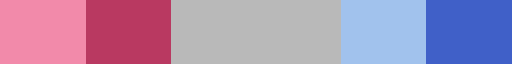

In [77]:
#benedictus color map
cmap = create_cmap(
    colors=[  "#F28AAAFF", "#B93961FF",   "#B9B9B9FF", "#B9B9B9FF", "#A1C2EDFF", "#4060C8FF"],
    cmap_type="discrete",
)
#9A133DFF, #B93961FF, #D8527CFF, #F28AAAFF, #F9B4C9FF, #F9E0E8FF, #FFFFFFFF, #EAF3FFFF, #C5DAF6FF, #A1C2EDFF, #6996E3FF, #4060C8FF, #1A318BFF
cmap

In [81]:
gdf["dataset"].unique()

array(['black vs white', 'cat vs dog', 'circle vs square',
       'coffee vs tea', 'hollywood vs bollywood', 'red vs blue',
       'suitcase vs rucksack', 'summer vs winter', 'sunrise vs sunset',
       'umbrella vs raincoat'], dtype=object)

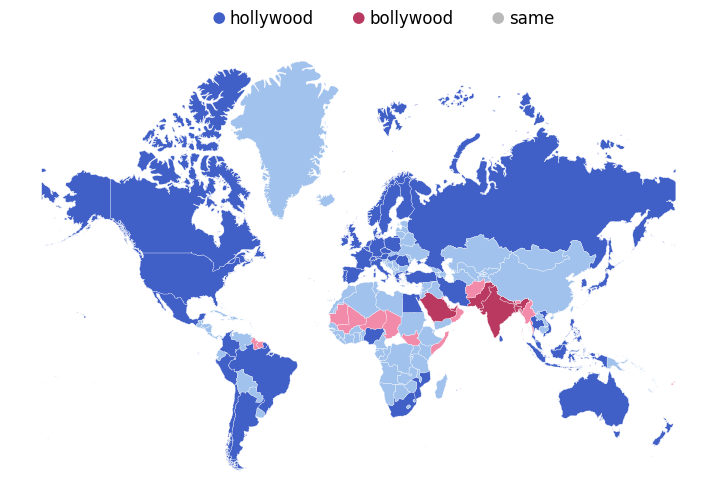

In [ ]:
### plot map 
fig, ax = plt.subplots(figsize=(9,9))

#filter for data set
dataset = gdf["dataset"].unique()[4]
gdf_plot = gdf[gdf["dataset"]==dataset]

#create custom legend
legend = {"y" :[1.05]*3,
          "x": [(i+0.05) * 2 for i in [0.1,  0.2,  0.3]],
          "s": [70]*3, 
          "c": [cmap.colors[5], cmap.colors[1], cmap.colors[3]], 
          "lw": [0]*3,
          "l" : [i for i in [gdf_plot["search1"].unique()[0], gdf_plot["search2"].unique()[0], "same"]]
          }

#set projection
gdf_plot = gdf_plot.to_crs(3857)

#plot
gdf_plot.plot(column="color_group_n", cmap=cmap, 
         ax=ax, linewidth=0.2, edgecolor="white")
ax.axis("off")

#add legend
import matplotlib.transforms as transforms
trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
ax.scatter(legend["x"],legend["y"], s=legend["s"], color=legend["c"], linewidth=legend["lw"],  transform=trans, clip_on=False)
for i, text in enumerate(legend["l"]):
    ax.text(legend["x"][i]+0.015,legend["y"][i], text, transform=trans, ha="left", va="center",
            fontsize=12)

#add title and footer







plt.show()

## Explore

In [51]:
cmap = create_cmap(
    colors=["#67A1E4FF", "#1778E7FF",  "#6E6E6EFF", "#A8ABACFF", "#D368ADFF", "#C91389FF",],
    cmap_type="discrete",
)

In [72]:
cmap = create_cmap(
    colors=[ "#8785B2FF", "#3A488AFF",  "#A8ABACFF", "#A8ABACFF", "#D95F30FF", "#BE3428FF"],
    cmap_type="discrete",
)

In [94]:
#teal rose
cmap = create_cmap(
    colors=[  "#B1C7B3FF", "#009392FF",  "#A8ABACFF", "#A8ABACFF", "#E5B9ADFF", "#D0587EFF"],
    cmap_type="discrete",
)

In [97]:
#tropic
cmap = create_cmap(
    colors=[  "#A7D3D4FF", "#009B9EFF",  "#A8ABACFF", "#A8ABACFF", "#E4C1D9FF", "#C75DABFF"],
    cmap_type="discrete",
)

In [85]:
#miami 2
cmap = create_cmap(
    colors=[  "#7FC7AFFF", "#3FB8AFFF",  "#A8ABACFF", "#A8ABACFF", "#FF9E9DFF", "#FF3D7FFF"],
    cmap_type="discrete",
)

In [ ]:
#red to blue
cmap = create_cmap(
    colors=[  "#92C5DEFF", "#2166ACFF",  "#A8ABACFF", "#A8ABACFF", "#F4A582FF", "#B2182BFF"],
    cmap_type="discrete",
)

In [105]:
#purple tangerines
cmap = create_cmap(
    colors=[  "#E7A8FBFF", "#AD72D6FF",  "#A8ABACFF", "#A8ABACFF", "#F8B150FF", "#C17D17FF"],
    cmap_type="discrete",
)

In [35]:
#benedictus
cmap = create_cmap(
    colors=[  "#F28AAAFF", "#B93961FF",   "#C7C7C7FF", "#C7C7C7FF", "#A1C2EDFF", "#4060C8FF"],
    cmap_type="discrete",
)

#9A133DFF, #B93961FF, #D8527CFF, #F28AAAFF, #F9B4C9FF, #F9E0E8FF, #FFFFFFFF,
#  #EAF3FFFF, #C5DAF6FF, #A1C2EDFF, #6996E3FF, #4060C8FF, #1A318BFF

In [ ]:
#blue2darkred
cmap = create_cmap(
    colors=[  "#72D9FFFF", "#264DFFFF",  "#A8ABACFF", "#A8ABACFF", "#FFAD72FF", "#D82632FF"],
    cmap_type="discrete",
)

In [129]:
#blue to orange
cmap = create_cmap(
    colors=[  "#4CC4FFFF", "#0080FFFF",  "#A8ABACFF", "#A8ABACFF", "#FFC44CFF", "#FF8000FF"],
    cmap_type="discrete",
)

In [138]:
#blue to orange
cmap = create_cmap(
    colors=[  "#E3ABA7FF", "#B1615CFF",  "#C7C7C7FF", "#C7C7C7FF", "#9D9DC7FF", "#5A5A83FF"],
    cmap_type="discrete",
)

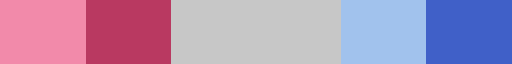

In [38]:
cmap

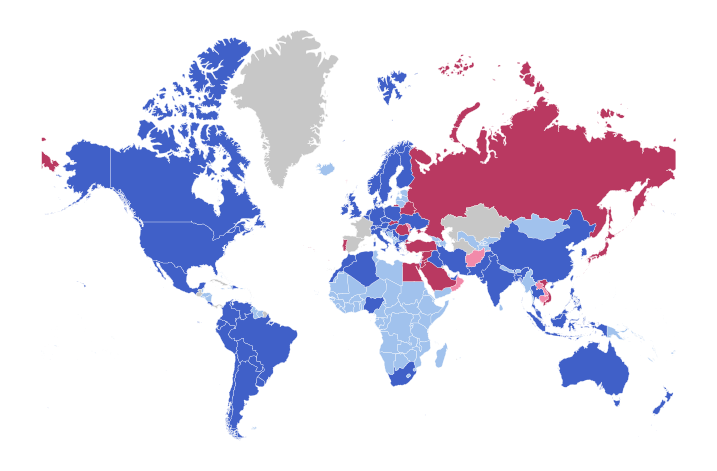

In [49]:
### plot map 
fig, ax = plt.subplots(figsize=(9,9))

#filter for data set
dataset = "black vs white"
gdf_plot = gdf[gdf["dataset"]==dataset]

#set projection
gdf_plot = gdf_plot.to_crs(3857)

#plot
gdf_plot.plot(column="color_group_n", cmap=cmap, 
         ax=ax, linewidth=0.2, edgecolor="white")
ax.axis("off")
plt.show()